In [18]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import gym
import matplotlib.pyplot as plt
import random
import argparse
from collections import OrderedDict
from copy import copy
import scipy
import scipy.linalg
import sys
sys.path.append("../utility")
sys.path.append("../train")
from Utility import data_collecter


from Utility import DerivativeLiftFunc, data_collecter,RBFLiftFunc

In [19]:
Methods = ["KoopmanDerivative","KoopmanRBF",\
            "KNonlinear","KNonlinearRNN","KoopmanU",\
            "KoopmanNonlinearA","KoopmanNonlinear",\
                ]

In [20]:
method_index = 1
# suffix = "CartPole1_26"
# env_name = "CartPole-v1"
# suffix = "Pendulum1_26"
# env_name = "Pendulum-v1"
suffix = "DampingPendulum1_26"
env_name = "DampingPendulum"
# suffix = "MountainCarContinuous1_26"
# env_name = "MountainCarContinuous-v0"

In [21]:
# Kd = np.load("Prediction_Results/"+"Kd_"+env_name+"_KoopmanRBF"+".npy")
Kd = np.load("../Prediction_Results/Samples/"+"Kd_"+env_name+"_KoopmanRBFsamples{}".format(20000)+".npz")["Kd"]
Data_collecter = data_collecter(env_name)
Nstate = Data_collecter.Nstates
udim = Data_collecter.udim
Nrbf = 50
LiftFunc = RBFLiftFunc(env_name,Nstate,udim,Nrbf,Data_collecter.observation_space)
NKoopman = LiftFunc.NKoopman

In [22]:

def Prepare_LQR(env_name):
    x_ref = np.zeros(Nstate)
    if env_name.startswith("CartPole"):
        Q = np.zeros((NKoopman,NKoopman))
        Q[1,1] = 0.01
        Q[2,2] = 5.0
        Q[3,3] = 0.01
        R = 0.001*np.eye(1)
        reset_state=  [0.0,0.0,-0.3,0]
    elif env_name.startswith("Pendulum"):
        Q = np.zeros((NKoopman,NKoopman))
        Q[0,0] = 5.0
        Q[1,1] = 0.01
        R = 0.001*np.eye(1)
        reset_state = [-3.0,0.5]
    elif env_name.startswith("DampingPendulum"):
        Q = np.zeros((NKoopman,NKoopman))
        Q[0,0] = 5.0
        Q[1,1] = 0.01
        R = 0.08*np.eye(1)
        reset_state = [-2.5,0.1]   
    elif env_name.startswith("MountainCarContinuous"):
        Q = np.zeros((NKoopman,NKoopman))
        Q[0,0] = 5.0
        Q[1,1] = 0.01
        R = 0.001*np.eye(1)
        reset_state = [0.5,0.0]  
        x_ref[0] = 0.45
    Q = np.matrix(Q)
    R = np.matrix(R)
    return Q,R,reset_state,x_ref

[[ -2.5          0.1        -10.88332795  -9.77815765  17.30616579
   34.91831953  35.61047001  31.70904382  33.87777142   1.58181858
    0.96833671  48.10071724  24.54380977  -0.6315207  -10.35896008
   32.54880063  -2.14121275  11.37123857  49.34237493  27.19449375
   26.65629389   2.82144788 -11.83062806   0.09672695   7.01820844
   16.55485551 -13.50443442 -13.79963253 -12.0155787   -3.60442535
   46.28802419   4.47907279  -4.34197975  23.37214654   8.9163392
   49.1923974  -16.07527538   6.94439224   3.31716525  33.8188762
   31.46208705  42.46949637  -0.66916863   3.81825832 -16.64296172
   17.53746693  19.82264788   8.26817139  39.28206537 -13.03572227
   26.43858926 -12.40322706]]
[[-2.15077912e+00  3.28270329e+01  3.75696593e+03  4.74340002e+03
   3.83328255e+03  3.53788415e+03  3.38880097e+03  3.16619193e+03
   2.91471633e+03  3.78015655e+03  3.52094254e+03  4.74031004e+03
   4.26175735e+03  3.25138033e+03  3.70550204e+03  4.07309185e+03
   3.81293740e+03  4.11108463e+03  4.8

/home/xyrrrrrrrr/202509newwork/RDKRC1/control/../utility/Utility.py:233: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sn = odeint(self.single_pendulum, self.s0, [0, self.dt], args=(u[0],))


[[-4.71611689e+00 -3.20189638e+05  1.29962982e+12  1.29959950e+12
   1.29962900e+12  1.29963984e+12  1.29964481e+12  1.29965200e+12
   1.29966074e+12  1.29962953e+12  1.29963794e+12  1.29960264e+12
   1.29961588e+12  1.29964693e+12  1.29963148e+12  1.29962238e+12
   1.29962821e+12  1.29961972e+12  1.29959868e+12  1.29962029e+12
   1.29965786e+12  1.29966126e+12  1.29959900e+12  1.29962068e+12
   1.29964126e+12  1.29963475e+12  1.29965677e+12  1.29964893e+12
   1.29961417e+12  1.29961361e+12  1.29959668e+12  1.29965649e+12
   1.29959760e+12  1.29960903e+12  1.29963685e+12  1.29960237e+12
   1.29966282e+12  1.29965377e+12  1.29962234e+12  1.29964014e+12
   1.29960263e+12  1.29961789e+12  1.29964349e+12  1.29960681e+12
   1.29965216e+12  1.29965496e+12  1.29960495e+12  1.29960925e+12
   1.29962435e+12  1.29965462e+12  1.29959746e+12  1.29959784e+12]]
[[-4.71825925e+00  1.17645629e+05  1.61593772e+11  1.61604064e+11
   1.61594049e+11  1.61590372e+11  1.61588683e+11  1.61586244e+11
   1.615

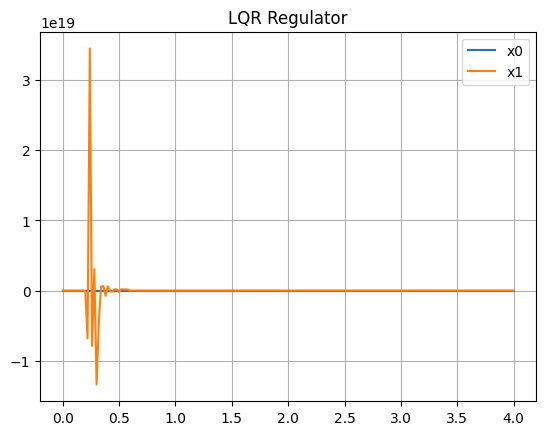

In [31]:
Ad = Kd[:NKoopman,:NKoopman]
Bd = Kd[:NKoopman,NKoopman:]
env = Data_collecter.env
env.reset()
import lqr
import time
Ad = np.matrix(Ad)
Bd = np.matrix(Bd)
Q,R,reset_state,x_ref = Prepare_LQR(env_name)
Kopt = lqr.lqr_regulator_k(Ad,Bd,Q,R)
observation_list = []
observation = np.array(env.reset_state(reset_state))
x0 = np.matrix(LiftFunc.Psi_s(observation))
# x_ref_lift = LiftFunc.Psi_s(x_ref).reshape(NKoopman,1)
x_ref_lift = LiftFunc.Psi_s(x_ref).reshape(1,NKoopman)
observation_list.append(x0[:Nstate].reshape(-1,1))
# print(Kopt)
u_list = []
steps = 200
# umax = 100
for i in range(steps):
    # env.render()
    print((x0-x_ref_lift).reshape(NKoopman))
    u = -Kopt*((x0-x_ref_lift).reshape(NKoopman, 1))
    # u = max(-umax,min(umax,u[0,0]))
    # print(type(u[0,0]),type(u))
    observation, reward, done, info = env.step(u[0,0])
    x0 = np.matrix(LiftFunc.Psi_s(observation))
    # x0 = Ad*x0+Bd*u
    observation_list.append(x0[:Nstate].reshape(-1,1))
    u_list.append(u)
    # time.sleep(0.1)

observations = np.concatenate(observation_list,axis=1)
u_list = np.array(u_list).reshape(-1)
time_history = np.arange(steps+1)*env.dt
for i in range(Nstate):
    plt.plot(time_history, observations[i,:].reshape(-1,1), label="x{}".format(i))
plt.grid(True)
plt.title("LQR Regulator")
plt.legend()
plt.show()